In [1]:
import os

import numpy as np
from netCDF4 import Dataset

import seaborn as sns
from tqdm import tqdm
from glob import glob
import pandas as pd
import time

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.client import device_lib

print(tf.__version__)
print(device_lib.list_local_devices())

2023-03-22 09:44:49.605937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.11.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9238765421731979694
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23290052608
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17140123913443126941
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 23023714304
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1454348167062564290
physical_device_desc: "device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6"
xla_global_id: 2144165316
, name: "/device:GPU:2"
device_type: "GPU"
memory_limit: 23290052608
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16392348715875110258
physical_device_desc: "device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6"
xla_global_id: 1651660799
, name: "/dev

In [2]:
path = '/home/workspace'
data_path = os.path.join(path,'cmaqProjectdata')
proj_path = os.path.join(path,'repos','cmaqProject')

In [3]:
checkpoint_dir = os.path.join(proj_path,'models','training_checkpoints',"model_conmat_cmaq_3_checkpoint")
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint_prefix

'/home/workspace/repos/cmaqProject/models/training_checkpoints/model_conmat_cmaq_3_checkpoint/ckpt'

In [4]:
BATCH_SIZE = 8
EPOCH = 1
shuffle_buffer_size = 100
train_set_len = 100

INPUT_SHAPE = [119]
OUTPUT_CHANNELS = 1

## 데이터셋

In [5]:

### 데이터셋
avg_conc_path_list = glob(os.path.join(data_path,"연평균자료","concentration","*"))
avg_conc_path_info_df = pd.DataFrame()
avg_conc_path_info_df.loc[:,'path'] = avg_conc_path_list
avg_conc_path_info_df.loc[:,'Run'] = [int(path.split("/")[-1].split(".")[1]) for path in avg_conc_path_list]

avg_ems_path_list = glob(os.path.join(data_path,"연평균자료","emission","*"))
avg_ems_path_info_df = pd.DataFrame()
avg_ems_path_info_df.loc[:,'path_ems'] = avg_ems_path_list
avg_ems_path_info_df.loc[:,'Run'] = [int(path.split("/")[-1].split(".")[1]) for path in avg_ems_path_list]

cont_matrix = pd.read_csv(os.path.join(data_path,"연평균자료","02_Emission_0518.csv"))

merged_info_df = pd.merge(avg_conc_path_info_df, avg_ems_path_info_df, how='left', on='Run')
merged_info_df = pd.merge(merged_info_df, cont_matrix, how='left', on='Run')
merged_info_df = merged_info_df.sort_values('Run')
merged_info_df.index = range(len(merged_info_df))


target_arr = np.concatenate([np.array(Dataset(path, 'r').variables['PM2_5'][0,0,8:-10,2:-1])[np.newaxis,:,:] for path in merged_info_df.path.tolist()])[:,:,:,None]


smoke_list = [Dataset(path, 'r') for path in merged_info_df.path_ems.tolist()]
smoke_chem_list = ['SO2', 'PM2_5', 'NOx', 'VOCs', 'NH3', 'CO']
smoke_val_list = []
for i in smoke_chem_list:
    smoke_arr_i = np.concatenate([np.array(Dataset(path, 'r').variables[i][0,0,8:-10,2:-1])[np.newaxis,:,:] for path in merged_info_df.path_ems.tolist()])[:,:,:,None]
    smoke_val_list.append(smoke_arr_i)

smoke_arr = np.concatenate(smoke_val_list, axis = 3)
smoke_arr.shape, target_arr.shape

input_cols = list(set(merged_info_df.columns) - set(['path','Run','path_ems']))

train_input = merged_info_df.loc[:,input_cols].values[:train_set_len]
test_input = merged_info_df.loc[:,input_cols].values[train_set_len:]

train_output = target_arr[:train_set_len]
test_output = target_arr[train_set_len:]

train_input_ds = tf.data.Dataset.from_tensor_slices(train_input)
train_target_ds = tf.data.Dataset.from_tensor_slices(train_output)

test_input_ds = tf.data.Dataset.from_tensor_slices(test_input)
test_target_ds = tf.data.Dataset.from_tensor_slices(test_output)


train_ds = tf.data.Dataset.zip((train_input_ds, train_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)
test_ds = tf.data.Dataset.zip((test_input_ds, test_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)

# input_cols = list(set(merged_info_df.columns) - set(['path','Run','path_ems']))

# train_input = merged_info_df.loc[:,input_cols].values[:train_set_len]
# test_input = merged_info_df.loc[:,input_cols].values[train_set_len:]

# train_output = target_arr[:train_set_len]
# test_output = target_arr[train_set_len:]

# train_smoke = smoke_arr[:train_set_len]
# test_smoke = smoke_arr[train_set_len:]

# train_input_ds = tf.data.Dataset.from_tensor_slices(train_input)
# train_target_ds = tf.data.Dataset.from_tensor_slices(train_output)
# train_smoke_ds = tf.data.Dataset.from_tensor_slices(train_smoke)

# test_input_ds = tf.data.Dataset.from_tensor_slices(test_input)
# test_target_ds = tf.data.Dataset.from_tensor_slices(test_output)
# test_smoke_ds = tf.data.Dataset.from_tensor_slices(test_smoke)

# train_ds = tf.data.Dataset.zip((train_input_ds, train_smoke_ds, train_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)
# test_ds = tf.data.Dataset.zip((test_input_ds, test_smoke_ds, test_target_ds)).batch(BATCH_SIZE).shuffle(shuffle_buffer_size)

# train_ds = ds.take(train_set_len) 
# test_ds = ds.skip(train_set_len)

In [6]:
train_input.shape, test_input.shape, 

((100, 119), (20, 119))

In [7]:
train_output.shape, test_output.shape, 

((100, 64, 64, 1), (20, 64, 64, 1))

## 모델

In [8]:
class Downsample(tf.keras.layers.Layer):
    def __init__(self, filters, size, apply_batchnorm=True):
        super(Downsample, self).__init__()
        self.initializer = tf.random_normal_initializer(0., 0.02)
        self.layer_stack = []

        self.layer_stack.append(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                kernel_initializer=self.initializer, use_bias=False))
        if apply_batchnorm:
            self.layer_stack.append(tf.keras.layers.BatchNormalization())
        self.layer_stack.append(tf.keras.layers.LeakyReLU())


    def call(self, inputs):
        x = inputs
        for layer_id in self.layer_stack:
            x = layer_id(x)

        return x
    

class Upsample(tf.keras.layers.Layer):
    def __init__(self, filters, size, apply_dropout=False):
        super(Upsample, self).__init__()
        self.initializer = tf.random_normal_initializer(0., 0.02)
        self.layer_stack = []

        self.layer_stack.append(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=self.initializer,
                                    use_bias=False))
        self.layer_stack.append(tf.keras.layers.BatchNormalization())
        if apply_dropout:
            self.layer_stack.append(tf.keras.layers.Dropout(0.5))
        self.layer_stack.append(tf.keras.layers.ReLU())
        
    def call(self, inputs):
        x = inputs
        for layer_id in self.layer_stack:
            x = layer_id(x)
        return x
    


class Generator(tf.keras.Model): 
    def __init__(self,base_map): 
        super(Generator, self).__init__()

        # self.base_map = base_map
        self.base_map = tf.concat([smoke_arr[0], base_map], axis = 2)
        self.concat_n = 32

        self.mulp_l = tf.keras.layers.Multiply()

        self.mlp_stack = [
            tf.keras.layers.Dense(256),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Dense(256),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Dense(self.concat_n),

            # 그냥 인풋데이터 처리하는 부분 # 이후 베이스맵이랑 베이스스모크 cnn레이어로 처리해서 아웃풋 채널수 맞춰주고 내적한 값으로 예측하도록
        ]

        self.left_stack = [
            tf.keras.layers.Conv2D(64, 3, padding='same',use_bias=True),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(64, 3, padding='same',use_bias=True),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),

            tf.keras.layers.Conv2D(self.concat_n, 3, padding='same',use_bias=True),
        ]

        self.down_stack = [
            Downsample(64, 3),  # (batch_size, 64, 64, 64)
            Downsample(128, 3),  # (batch_size, 32, 32, 128)
            Downsample(256, 3),  # (batch_size, 16, 16, 256)
            Downsample(512, 3),  # (batch_size, 8, 8, 512)
            Downsample(512, 3),  # (batch_size, 4, 4, 512)
        ]

        self.up_stack = [
            Upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
            Upsample(512, 3),  # (batch_size, 8, 8, 1024)
            Upsample(256, 3),  # (batch_size, 16, 16, 512)
            Upsample(128, 3),  # (batch_size, 32, 32, 256)
            Upsample(64, 3),  # (batch_size, 64, 64, 128)
        ]

        self.initializer = tf.random_normal_initializer(0., 0.02)
        # self.last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,


        self.last_stack = [
            tf.keras.layers.Conv2DTranspose(64,4,
                                                strides=2,
                                                padding='same',
                                                kernel_initializer=self.initializer,
                                                ),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(32, 3,
                                                # strides=2,
                                                padding='same',
                                                kernel_initializer=self.initializer,
                                                ),
            # tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(1, 3,
                                                # strides=2,
                                                padding='same',
                                                kernel_initializer=self.initializer,
                                                ),
                                                
                                                ]
        
    
    def call(self, input): 
        x = input    
        # x = tf.multiply(tf.keras.layers.Reshape((1,1, 119))(x), self.base_map)  # basemap shape == (64,64,1)
        x_left = tf.multiply(tf.ones([input.shape[0],1,1,1]), self.base_map)  # basemap shape == (64,64,1)
        

        # right_module
        for seq in self.mlp_stack:
            x = seq(x)
        
        # left_module

        for seq in self.left_stack:
            x_left = seq(x_left)
        
        

        x_after = tf.expand_dims(tf.einsum('bijk, bk ->bij', x_left, x),3)
        # x_after = tf.einsum('bijk, bk ->bijk', x_left, x)
        # print(x_after.shape)


        # # Downsampling through the model
        # skips = []
        # for down in self.down_stack:
        #     x_after = down(x_after)
        #     skips.append(x_after)

        # skips = reversed(skips[:-1])

        # # Upsampling and establishing the skip connections
        # for up, skip in zip(self.up_stack, skips):
        #     x_after = up(x_after)
        #     x_after = tf.keras.layers.Concatenate()([x_after, skip])

        # for last_layer in self.last_stack:
        #     x_after = last_layer(x_after)

        # # print(x_after.shape)
        return x_after


In [9]:
# 1번 시나리오 베이스맵으로 사용
loss_mse = tf.keras.losses.MeanSquaredError()
base_map = np.array(Dataset(merged_info_df.loc[merged_info_df.Run == 1,'path'].values[0], 'r').variables['PM2_5'][0,0,8:-10,2:-1])[:,:,np.newaxis]
## 모델 체크포인트 생성
generator_optimizer = tf.keras.optimizers.Adam(0.001)

generator = Generator(base_map)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 generator=generator,
                                 )

# ####### 저장된 모델 있을 경우 ##########
# manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)
# checkpoint.restore(manager.latest_checkpoint)

In [10]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(8, 8))
  # display_list = [test_input[0][0][:,:,:3], tar[0][:,:,0][::-1], prediction[0][::-1]]
  # title = ['Input', 'Ground Truth', 'Predicted Image']
  # print(prediction.shape, tar.shape)
  display_list = [tar[0][::-1], prediction[0][::-1]]
  title = ['Ground Truth', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

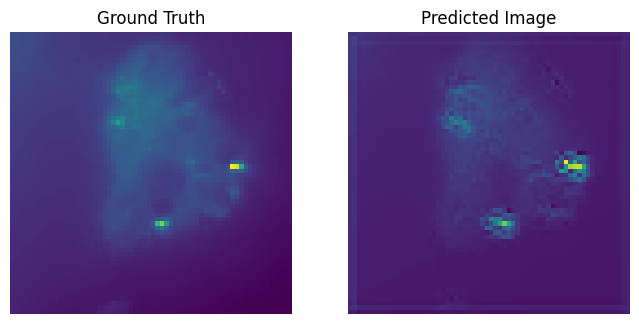

In [11]:
generate_images(generator, test_input[0:1], test_output[0:1])

* 학습

In [12]:
from IPython import display

In [13]:
import datetime
summary_writer = tf.summary.create_file_writer(os.path.join(checkpoint_prefix, "logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S")))

Time taken for 100 steps: 1.14 sec



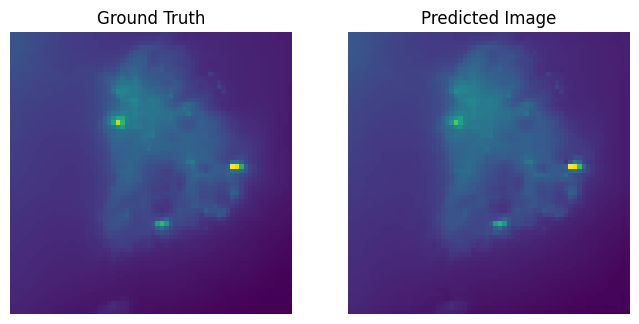

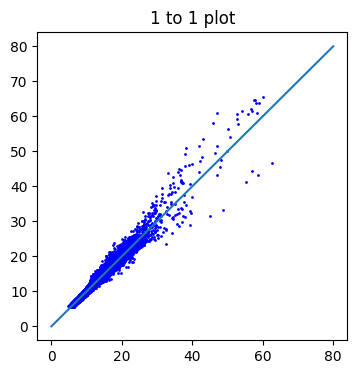

Step: 4900
..........

In [14]:
@tf.function
def train_step(input_image, target, step):
  # with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
  with tf.GradientTape() as gen_tape:
    gen_output = generator(input_image, training=True)
    l1_loss = loss_mse(target, gen_output)
  generator_gradients = gen_tape.gradient(l1_loss,
                                          generator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  # discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
  #                                             discriminator.trainable_variables))
  # with summary_writer.as_default():
  #   tf.summary.scalar('gen_total_loss', gen_total_loss, step=step)
  #   tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step)
  #   tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step)
  #   tf.summary.scalar('disc_loss', disc_loss, step=step)

steps = 5000
generator_optimizer = tf.keras.optimizers.Adam(0.0001)
example_input, example_target = next(iter(test_ds.take(1)))
start = time.time()

for step, (input_arr, target) in train_ds.repeat().take(steps).enumerate():
  
  if (step) % 100 == 0:
    display.clear_output(wait=True)

    if step != 0:
      print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')

    start = time.time()

    generate_images(generator, example_input, example_target)
    results = generator(test_input)
    

    plt.figure(figsize=(4, 4))
    
    plt.subplot(1, 1, 1)
    plt.title('1 to 1 plot')
    plt.plot(results.numpy().reshape(-1), test_output.reshape(-1),'bo', markersize=1)
    plt.plot([0,80],[0,80])
    # plt.axis('off')

    plt.show()

    print(f"Step: {step}")

  train_step(input_arr, target, step)

  # Training step
  if (step+1) % 10 == 0:
    print('.', end='', flush=True)


  # Save (checkpoint) the model every 5k steps
  if (step + 1) % 1000 == 0:
    checkpoint.save(file_prefix=checkpoint_prefix)

* 평가

In [15]:
results = generator(test_input)

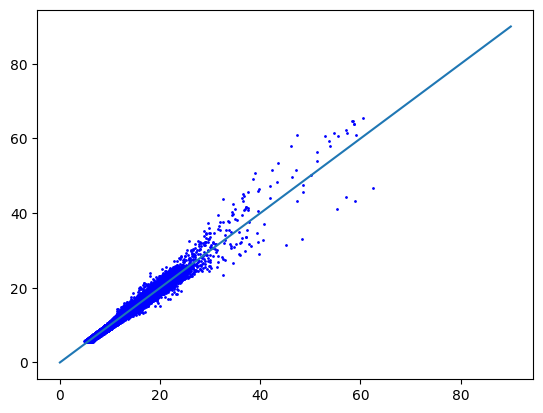

In [16]:
plt.plot(results.numpy().reshape(-1), test_output.reshape(-1),'bo', markersize=1)
plt.plot([0,90],[0,90])

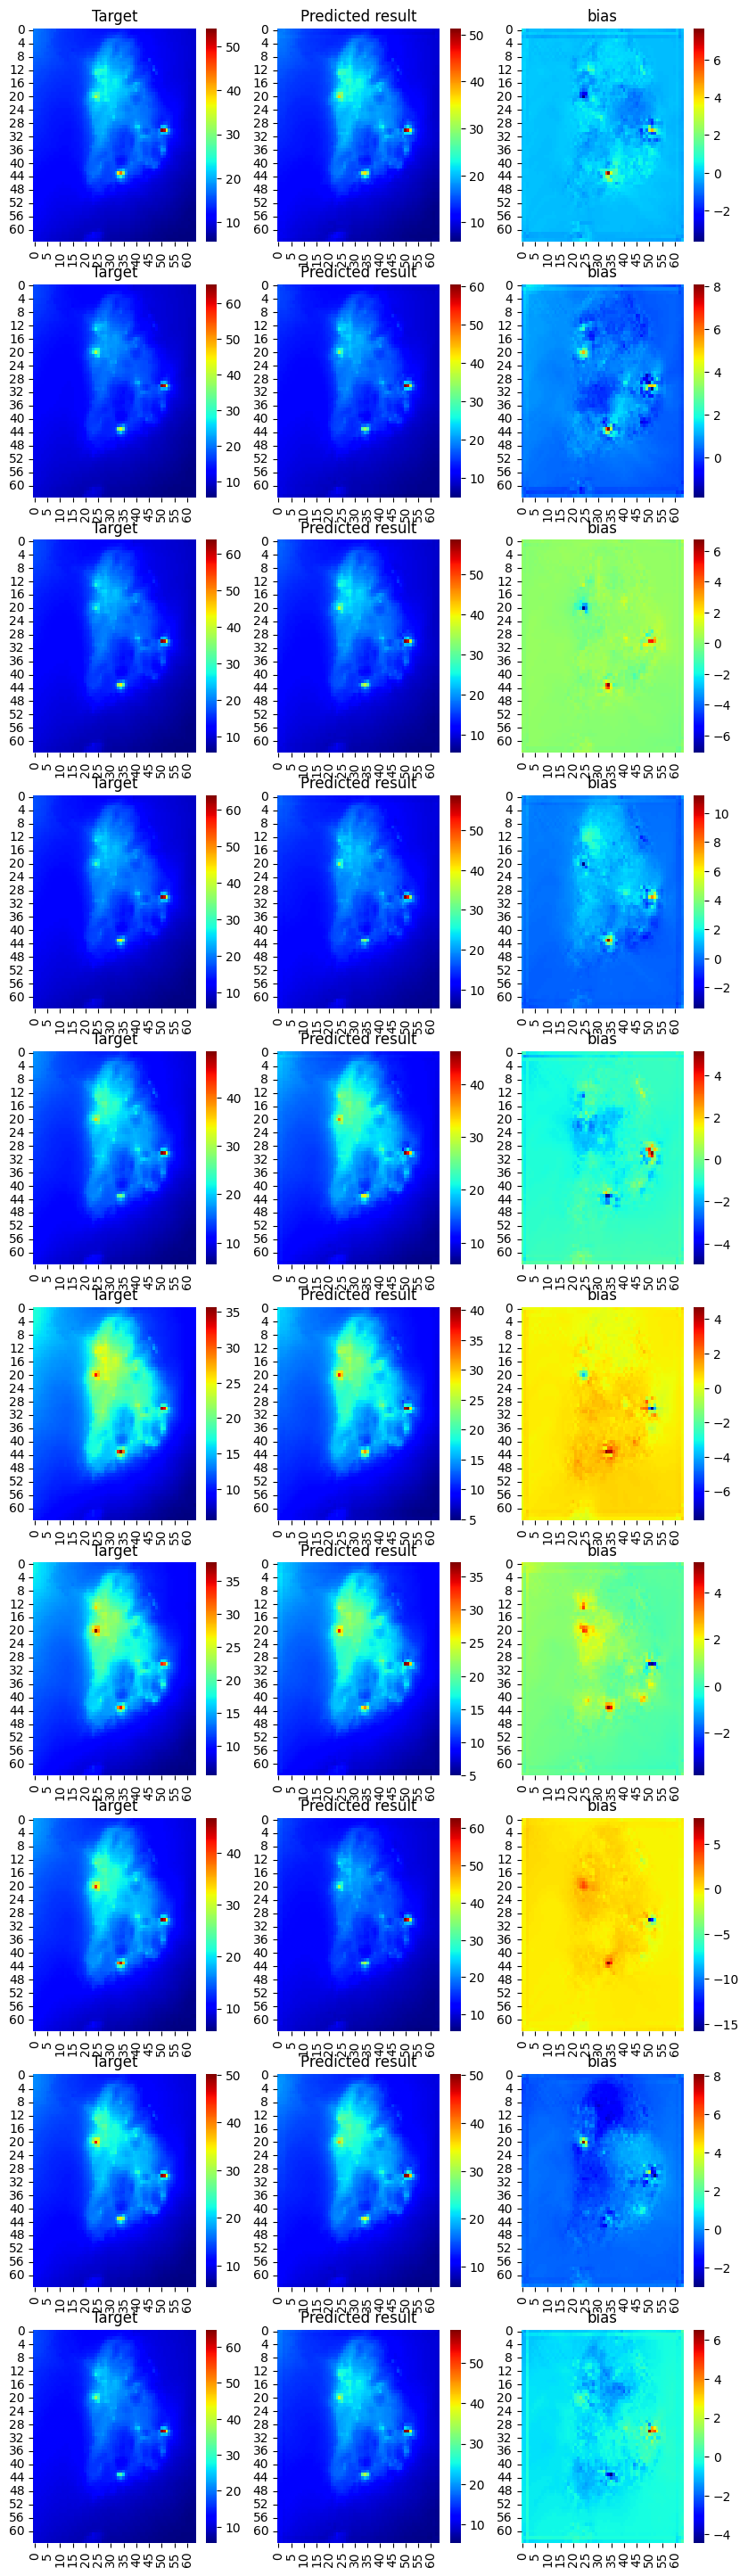

In [17]:
plt.figure(figsize=(10, 15*30))
j = 0

results = generator(test_input)
for i in range(len(results))[:10]:
  
  display_list = [test_output[i], results[i], test_output[i] - results[i]]
  title = ['Target','Predicted result', 'bias']
  
  for i in range(3):
    plt.subplot(121, 3, j + i + 1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    # plt.imshow(display_list[i][:,:,0][::-1])
    sns.heatmap(display_list[i][:,:,0][::-1], cmap='jet')
    # if i != 2:
    #   sns.heatmap(display_list[i][:,:,0][::-1], cmap='jet', vmax=80,vmin=0)
    # else:
    #   sns.heatmap(display_list[i][:,:,0][::-1], cmap='jet')
    # plt.axis('off')
  j += 3